### 01. Import Dependencies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


### 02. Load Data


In [2]:
df = pd.read_csv("data/processed/feature_binning.csv")
df.head()


,purchase_value,source,browser,sex,age,class,account_age_minutes,device_count,user_count_per_device,country
0,34,SEO,Chrome,M,Middle-aged,0,75111.37,1,1,Japan
1,16,Ads,Chrome,F,Middle-aged,0,299.07,1,1,United States
2,15,SEO,Opera,M,Middle-aged,1,0.02,12,12,United States
3,44,SEO,Safari,M,Middle-aged,0,8201.42,1,1,Unknown
4,39,Ads,Safari,M,Middle-aged,0,72691.02,1,1,United States


In [3]:
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")


Dataset shape: (144272, 10)

Column names: ['purchase_value', 'source', 'browser', 'sex', 'age', 'class', 'account_age_minutes', 'device_count', 'user_count_per_device', 'country']

Data types:
purchase_value             int64
source                    object
browser                   object
sex                       object
age                       object
class                      int64
account_age_minutes      float64
device_count               int64
user_count_per_device      int64
country                   object
dtype: object

Missing values:
purchase_value           0
source                   0
browser                  0
sex                      0
age                      0
class                    0
account_age_minutes      0
device_count             0
user_count_per_device    0
country                  0
dtype: int64


### 03. Target Variable Analysis


TARGET VARIABLE DISTRIBUTION

Class Counts:
class
0    136961
1      7311
Name: count, dtype: int64

Class Percentages:
class
0    94.932489
1     5.067511
Name: proportion, dtype: float64

Imbalance Ratio: 18.73:1 (Non-Fraud:Fraud)


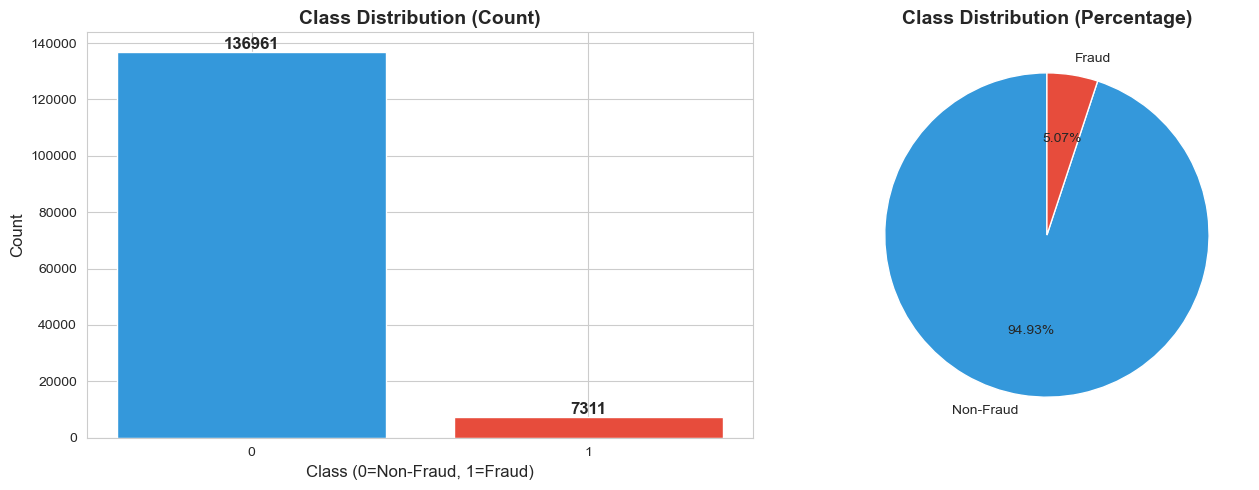

In [4]:
# Class distribution
class_counts = df['class'].value_counts()
class_percentages = df['class'].value_counts(normalize=True) * 100

print("=" * 50)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 50)
print(f"\nClass Counts:")
print(class_counts)
print(f"\nClass Percentages:")
print(class_percentages)
print(f"\nImbalance Ratio: {class_counts[0] / class_counts[1]:.2f}:1 (Non-Fraud:Fraud)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(class_counts.index, class_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Non-Fraud, 1=Fraud)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticks([0, 1])
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Percentage pie chart
axes[1].pie(class_percentages.values, labels=['Non-Fraud', 'Fraud'], 
            autopct='%1.2f%%', startangle=90, colors=['#3498db', '#e74c3c'])
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 04. Feature Type Identification


In [5]:
# Separate features by type
numerical_features = [
    'purchase_value',
    'account_age_minutes',
    'device_count',
    'user_count_per_device'
]

categorical_features = [
    'source',
    'browser',
    'sex',
    'country',
    'age'  # After binning, age is categorical
]

target = 'class'

print("Numerical Features:", numerical_features)
print("\nCategorical Features:", categorical_features)
print(f"\nTotal Features: {len(numerical_features) + len(categorical_features)}")


Numerical Features: ['purchase_value', 'account_age_minutes', 'device_count', 'user_count_per_device']

Categorical Features: ['source', 'browser', 'sex', 'country', 'age']

Total Features: 9


### 05. Univariate Analysis - Numerical Features by Class


In [6]:
# Statistical summary by class
print("=" * 80)
print("STATISTICAL SUMMARY BY CLASS - NUMERICAL FEATURES")
print("=" * 80)

for feature in numerical_features:
    print(f"\n{'='*80}")
    print(f"Feature: {feature.upper()}")
    print(f"{'='*80}")
    
    summary = df.groupby('class')[feature].describe()
    print(summary)
    
    # Statistical test (t-test for difference in means)
    fraud_values = df[df['class'] == 1][feature]
    non_fraud_values = df[df['class'] == 0][feature]
    
    t_stat, p_value = stats.ttest_ind(fraud_values, non_fraud_values)
    print(f"\nT-test: t-statistic={t_stat:.4f}, p-value={p_value:.4f}")
    print(f"Mean difference: {fraud_values.mean() - non_fraud_values.mean():.4f}")
    
    if p_value < 0.05:
        print("✓ Statistically significant difference (p < 0.05)")
    else:
        print("✗ No statistically significant difference (p >= 0.05)")


STATISTICAL SUMMARY BY CLASS - NUMERICAL FEATURES

Feature: PURCHASE_VALUE
          count       mean        std  min   25%   50%   75%    max
class                                                              
0      136961.0  36.929418  18.315064  9.0  22.0  35.0  49.0  154.0
1        7311.0  37.001368  18.382663  9.0  22.0  35.0  49.0  111.0

T-test: t-statistic=0.3272, p-value=0.7435
Mean difference: 0.0719
✗ No statistically significant difference (p >= 0.05)

Feature: ACCOUNT_AGE_MINUTES
          count          mean           std   min        25%       50%  \
class                                                                    
0      136961.0  86519.643140  49809.813494  2.28  43147.150  86581.85   
1        7311.0  78192.190789  54303.579720  0.02  29475.615  76928.12   

              75%        max  
class                         
0      129688.650  172799.53  
1      125259.765  172732.45  

T-test: t-statistic=-13.8621, p-value=0.0000
Mean difference: -8327.4524
✓ Stat

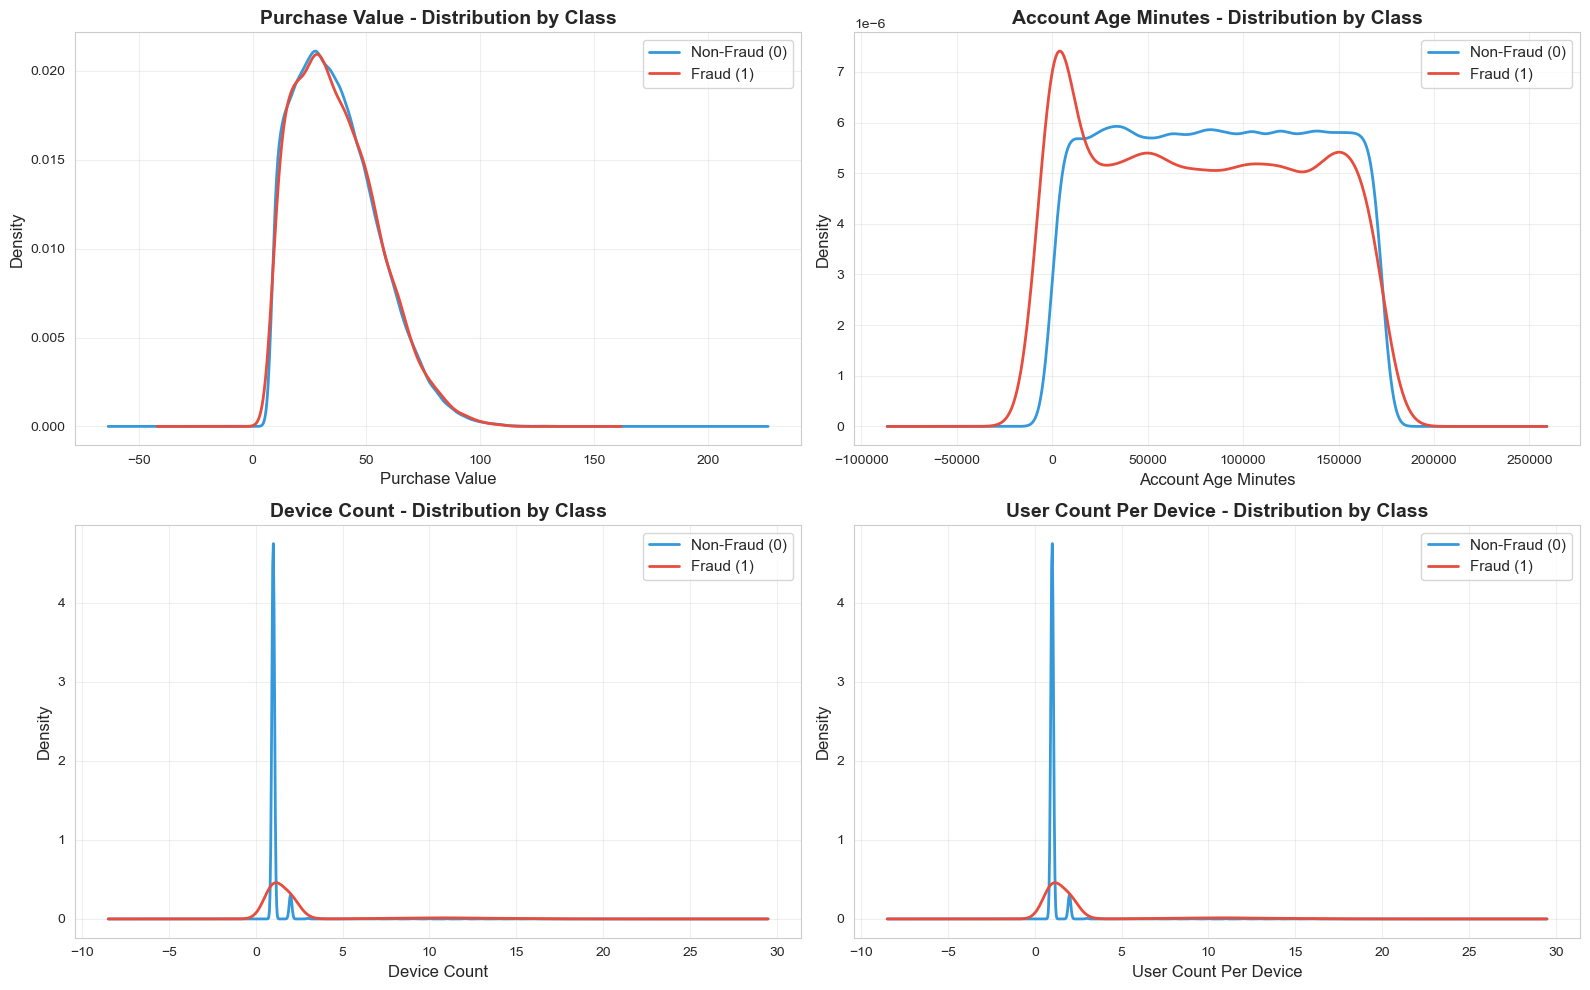

In [7]:
# Distribution plots for numerical features by class
n_features = len(numerical_features)
n_cols = 2
n_rows = (n_features + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    
    # KDE plots for each class
    df[df['class'] == 0][feature].plot(kind='kde', ax=ax, label='Non-Fraud (0)', color='#3498db', linewidth=2)
    df[df['class'] == 1][feature].plot(kind='kde', ax=ax, label='Fraud (1)', color='#e74c3c', linewidth=2)
    
    ax.set_title(f'{feature.replace("_", " ").title()} - Distribution by Class', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


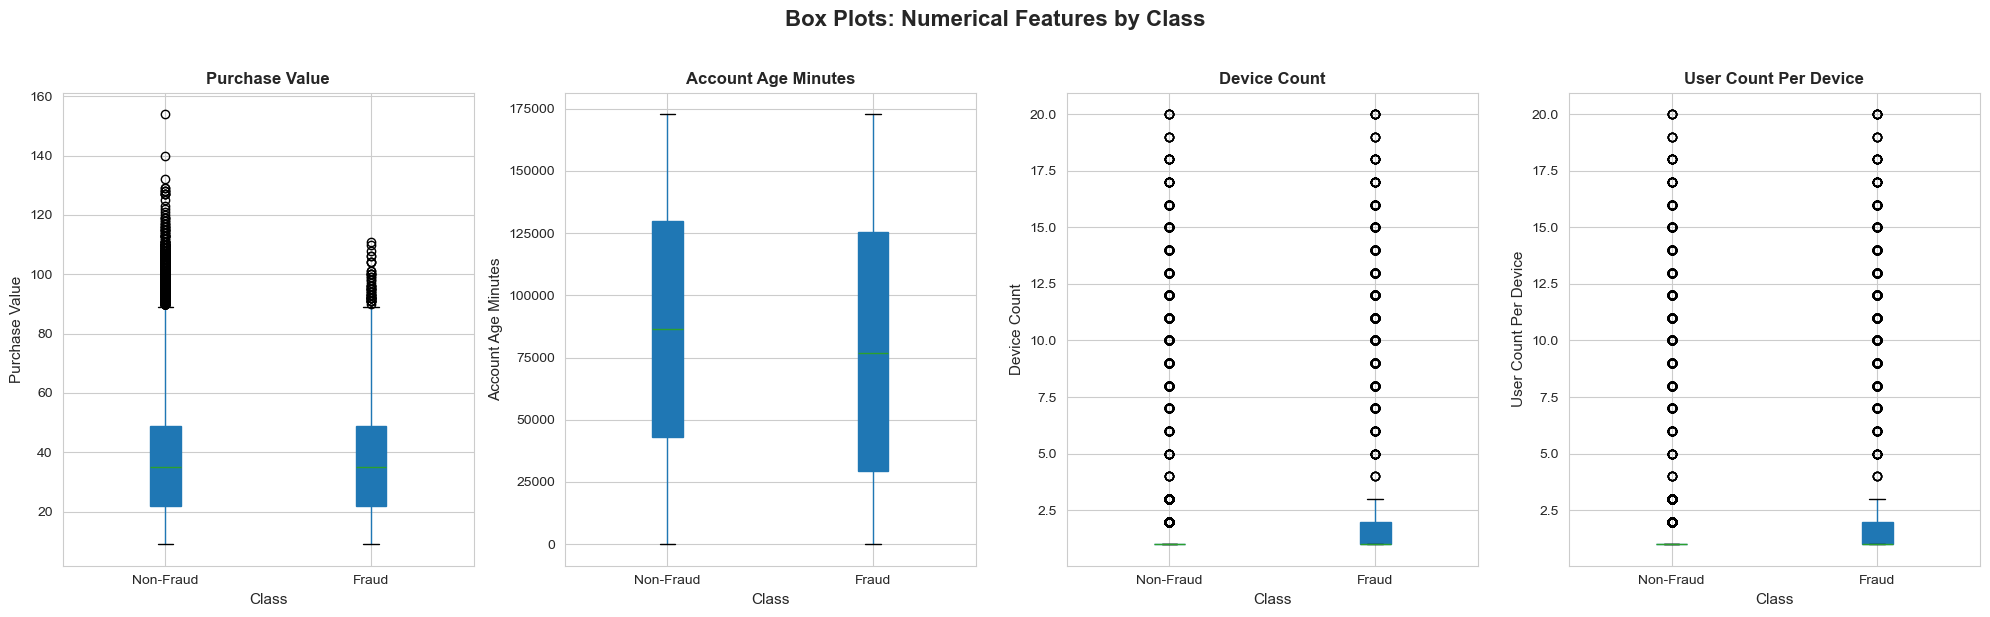

In [8]:
# Box plots for numerical features by class
fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 6))

for idx, feature in enumerate(numerical_features):
    df.boxplot(column=feature, by='class', ax=axes[idx], patch_artist=True)
    axes[idx].set_title(f'{feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class', fontsize=11)
    axes[idx].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_xticklabels(['Non-Fraud', 'Fraud'])
    
    # Color the boxes
    for patch in axes[idx].artists:
        patch.set_facecolor('#3498db' if patch.get_bbox().x0 < 0.5 else '#e74c3c')

plt.suptitle('Box Plots: Numerical Features by Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 06. Univariate Analysis - Categorical Features by Class


In [9]:
# Categorical feature analysis by class
print("=" * 80)
print("CATEGORICAL FEATURES ANALYSIS BY CLASS")
print("=" * 80)

for feature in categorical_features:
    print(f"\n{'='*80}")
    print(f"Feature: {feature.upper()}")
    print(f"{'='*80}")
    
    # Cross-tabulation
    crosstab = pd.crosstab(df[feature], df['class'], margins=True)
    crosstab_pct = pd.crosstab(df[feature], df['class'], normalize='index') * 100
    
    print("\nCount by Class:")
    print(crosstab)
    print("\nPercentage by Class (within each category):")
    print(crosstab_pct.round(2))
    
    # Chi-square test
    contingency_table = pd.crosstab(df[feature], df['class'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nChi-square test: chi2={chi2:.4f}, p-value={p_value:.4f}, dof={dof}")
    if p_value < 0.05:
        print("✓ Statistically significant association (p < 0.05)")
    else:
        print("✗ No statistically significant association (p >= 0.05)")


CATEGORICAL FEATURES ANALYSIS BY CLASS

Feature: SOURCE

Count by Class:
class        0     1     All
source                      
Ads      54368  2809   57177
Direct   27390  1742   29132
SEO      55203  2760   57963
All     136961  7311  144272

Percentage by Class (within each category):
class       0     1
source             
Ads     95.09  4.91
Direct  94.02  5.98
SEO     95.24  4.76

Chi-square test: chi2=64.5014, p-value=0.0000, dof=2
✓ Statistically significant association (p < 0.05)

Feature: BROWSER

Count by Class:
class         0     1     All
browser                      
Chrome    55363  2981   58344
FireFox   22268  1191   23459
IE        33540  1752   35292
Opera      3348   176    3524
Safari    22442  1211   23653
All      136961  7311  144272

Percentage by Class (within each category):
class        0     1
browser             
Chrome   94.89  5.11
FireFox  94.92  5.08
IE       95.04  4.96
Opera    95.01  4.99
Safari   94.88  5.12

Chi-square test: chi2=1.1721, p-val

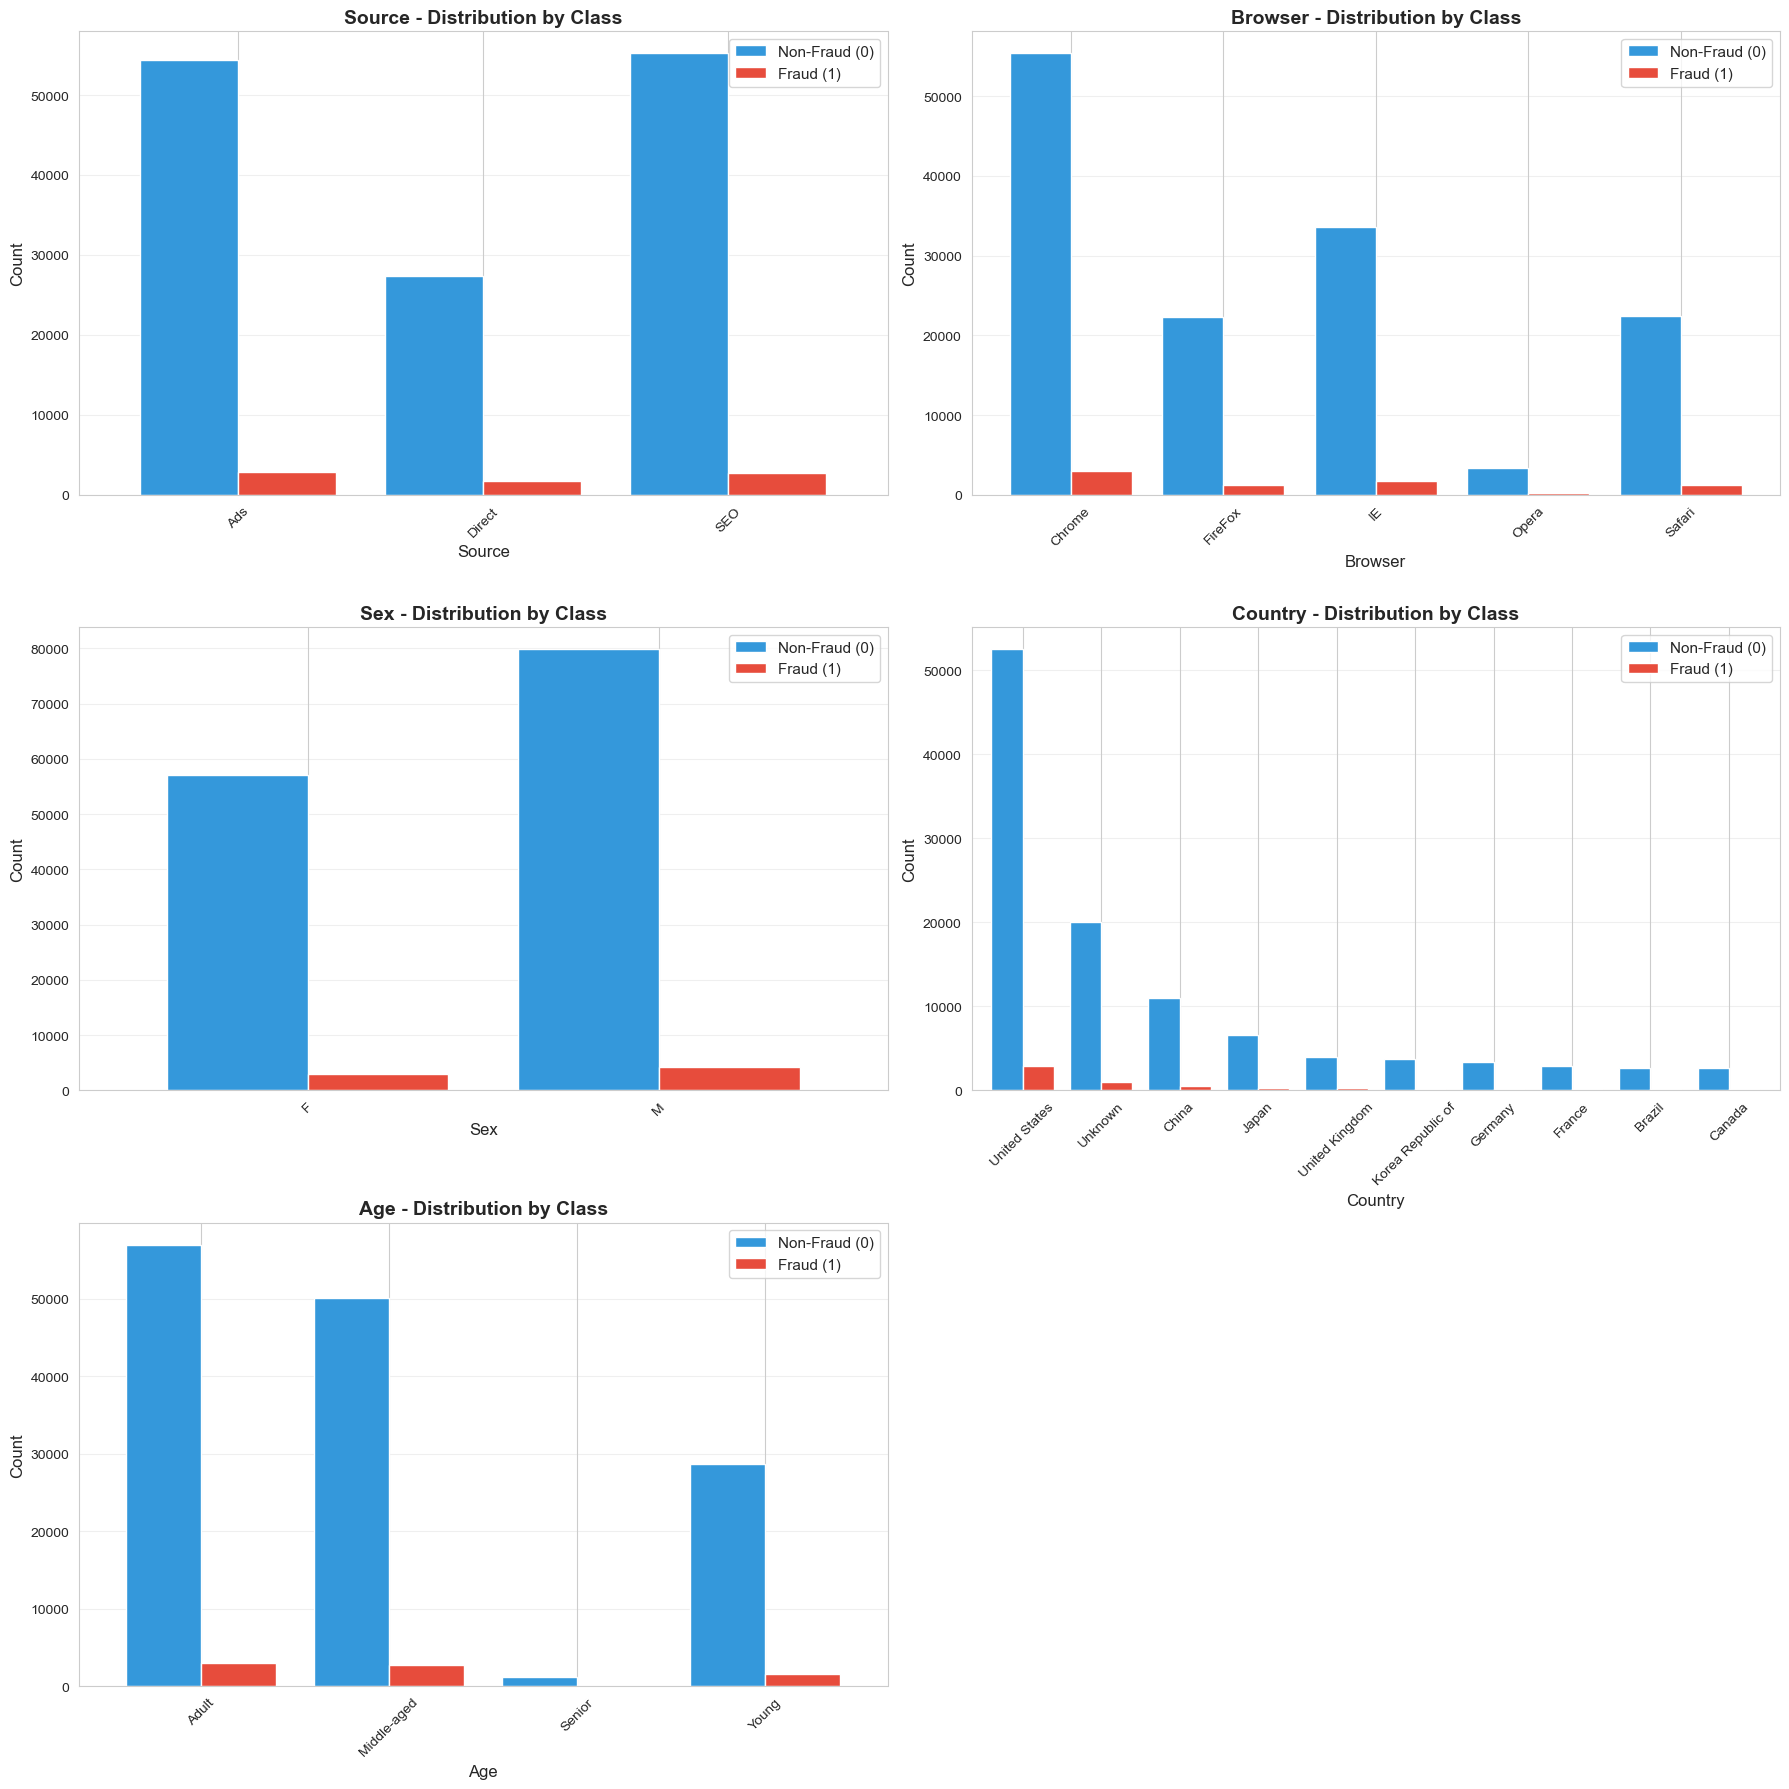

In [10]:
# Visualize categorical features by class
n_features = len(categorical_features)
n_cols = 2
n_rows = (n_features + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(categorical_features):
    ax = axes[idx]
    
    # Create grouped bar chart
    crosstab = pd.crosstab(df[feature], df['class'])
    
    # Get top categories if too many
    if len(crosstab) > 10:
        top_categories = crosstab.sum(axis=1).nlargest(10).index
        crosstab = crosstab.loc[top_categories]
    
    crosstab.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'], width=0.8)
    ax.set_title(f'{feature.replace("_", " ").title()} - Distribution by Class', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(['Non-Fraud (0)', 'Fraud (1)'], fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


### 07. Correlation Analysis - Feature-Feature Correlations


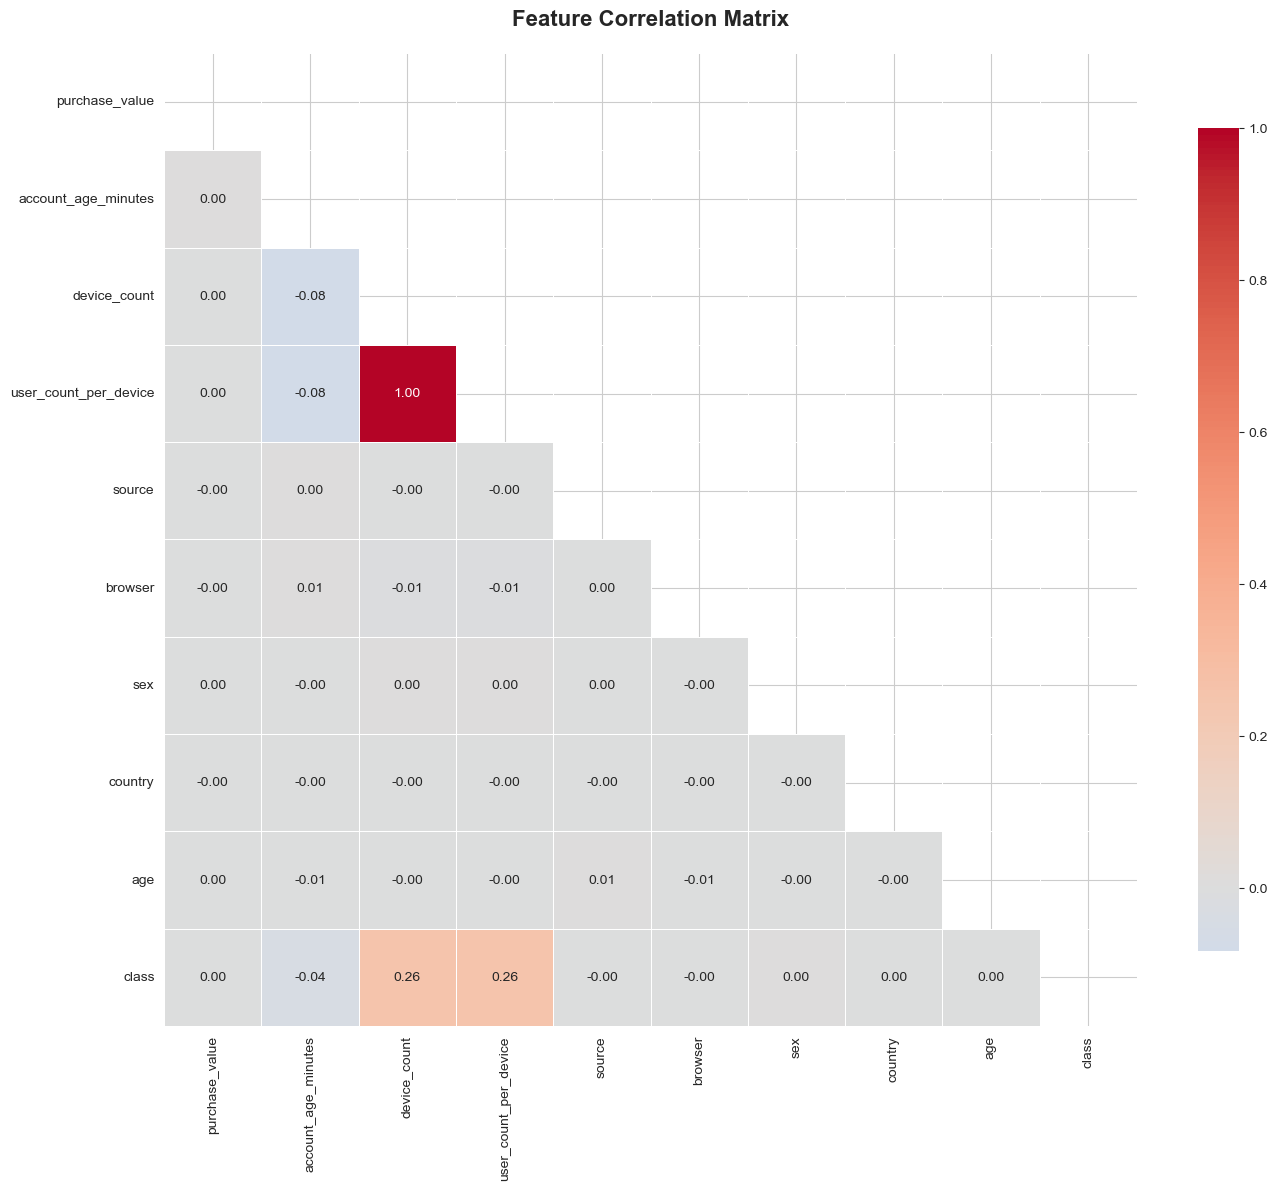

In [11]:
# For correlation, we need to encode categorical variables temporarily
df_encoded = df.copy()

# Label encode categorical variables for correlation
from sklearn.preprocessing import LabelEncoder

le_dict = {}
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# Calculate correlation matrix
correlation_matrix = df_encoded[numerical_features + categorical_features + [target]].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            mask=mask,
            cbar_kws={"shrink": 0.8},
            linewidths=0.5,
            annot_kws={'size': 10})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


CORRELATION WITH TARGET VARIABLE (CLASS)

Features sorted by absolute correlation with target:
device_count             0.259694
user_count_per_device    0.259694
sex                      0.002989
country                  0.001080
purchase_value           0.000861
age                      0.000549
browser                 -0.000633
source                  -0.003142
account_age_minutes     -0.036471


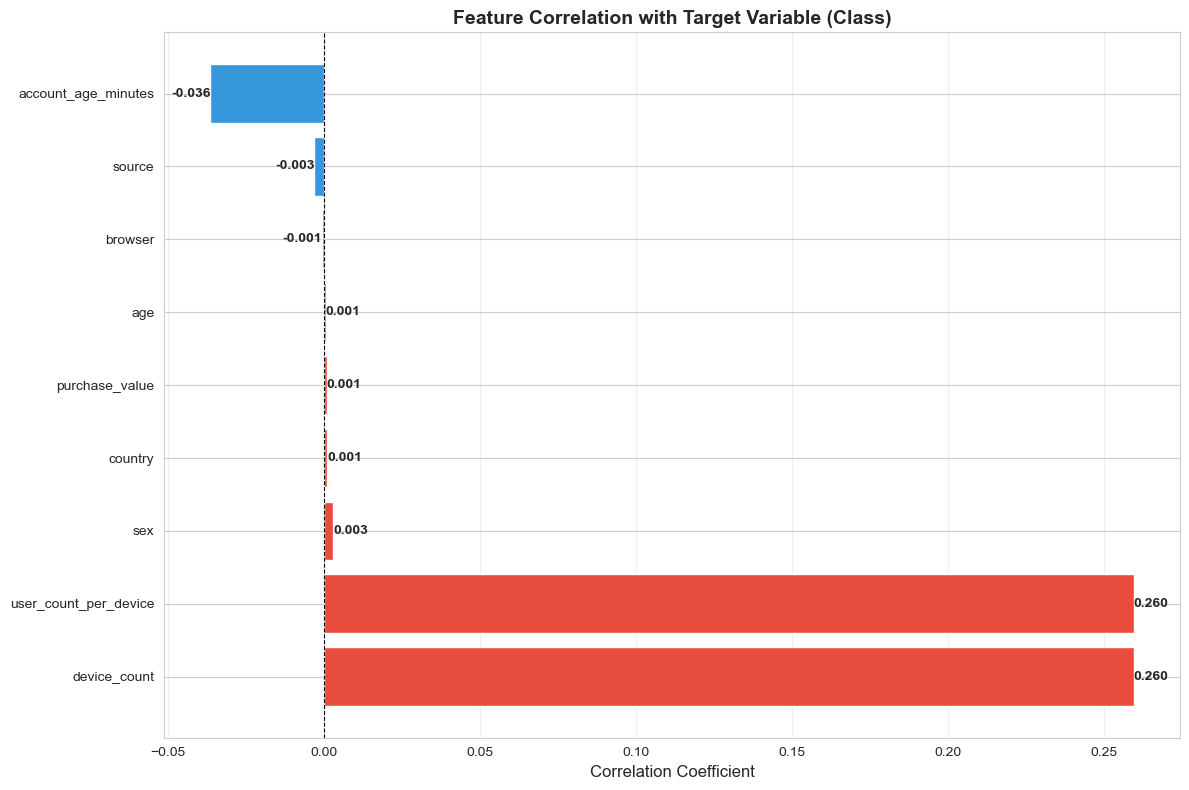

In [12]:
# Correlation with target variable
target_correlations = correlation_matrix[target].sort_values(ascending=False)
target_correlations = target_correlations.drop(target)  # Remove self-correlation

print("=" * 80)
print("CORRELATION WITH TARGET VARIABLE (CLASS)")
print("=" * 80)
print("\nFeatures sorted by absolute correlation with target:")
print(target_correlations.to_string())

# Visualize
plt.figure(figsize=(12, 8))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in target_correlations.values]
bars = plt.barh(range(len(target_correlations)), target_correlations.values, color=colors)
plt.yticks(range(len(target_correlations)), target_correlations.index)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.title('Feature Correlation with Target Variable (Class)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, val) in enumerate(target_correlations.items()):
    plt.text(val, i, f'{val:.3f}', va='center', 
             ha='left' if val > 0 else 'right', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### 08. Bivariate Analysis - Feature Interactions with Target


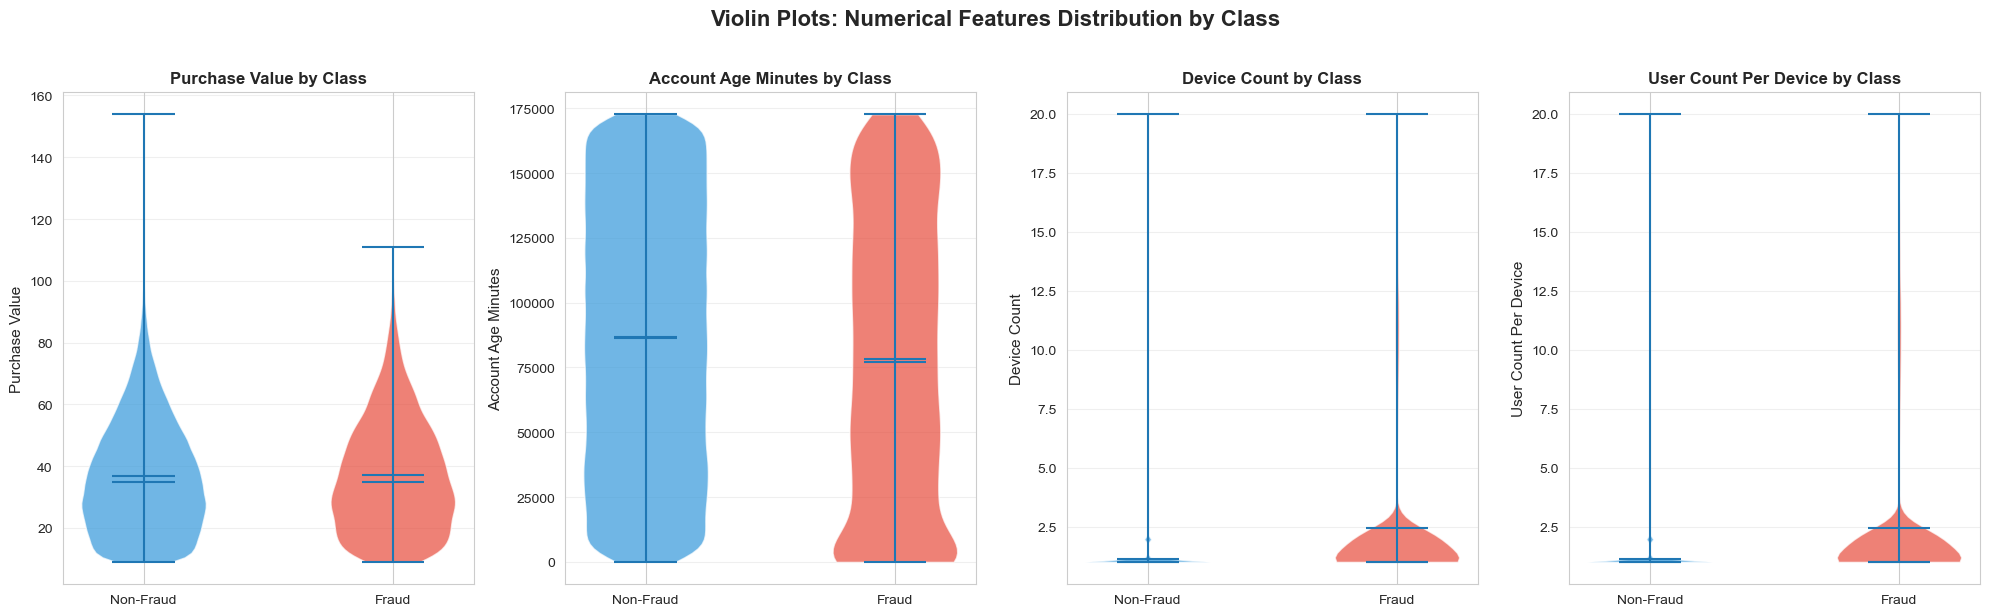

In [13]:
# Numerical features vs Target - Violin plots
fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 6))

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    
    # Create violin plot
    data_to_plot = [df[df['class'] == 0][feature].values, 
                    df[df['class'] == 1][feature].values]
    
    parts = ax.violinplot(data_to_plot, positions=[0, 1], showmeans=True, showmedians=True)
    
    # Customize colors
    for pc in parts['bodies']:
        pc.set_facecolor('#3498db')
        pc.set_alpha(0.7)
    
    parts['bodies'][1].set_facecolor('#e74c3c')
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Non-Fraud', 'Fraud'])
    ax.set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
    ax.set_title(f'{feature.replace("_", " ").title()} by Class', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Violin Plots: Numerical Features Distribution by Class', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 09. Fraud Rate Analysis by Categorical Features


FRAUD RATE BY CATEGORICAL FEATURES

Feature: SOURCE
source  Fraud_Rate  Count
Direct    5.979679  29132
   Ads    4.912815  57177
   SEO    4.761658  57963


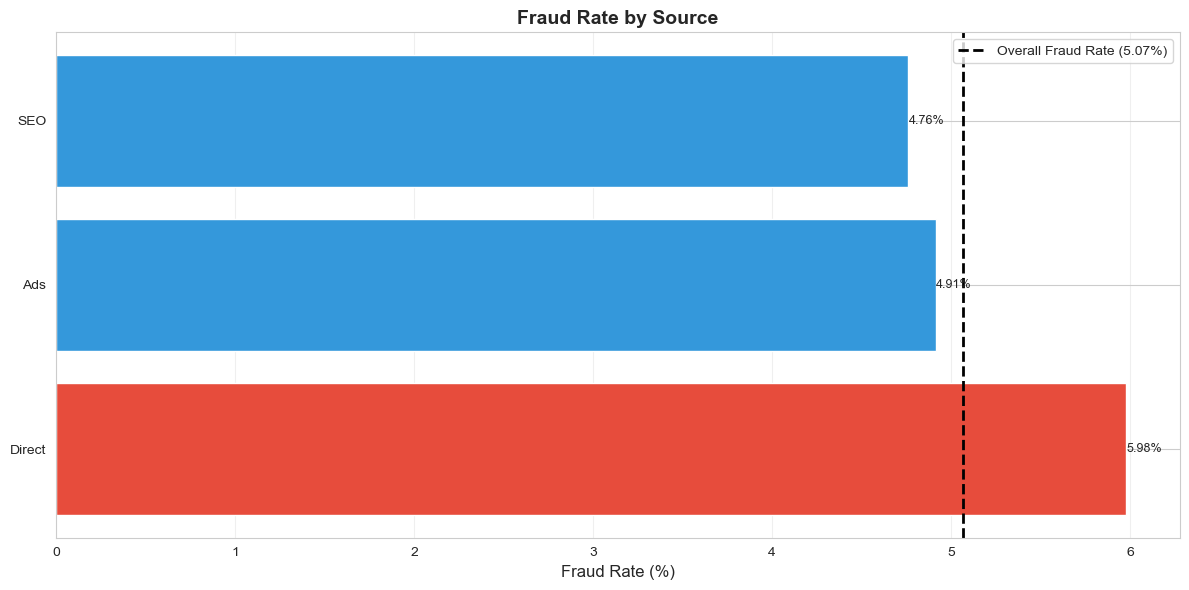


Feature: BROWSER
browser  Fraud_Rate  Count
 Safari    5.119858  23653
 Chrome    5.109351  58344
FireFox    5.076943  23459
  Opera    4.994325   3524
     IE    4.964298  35292


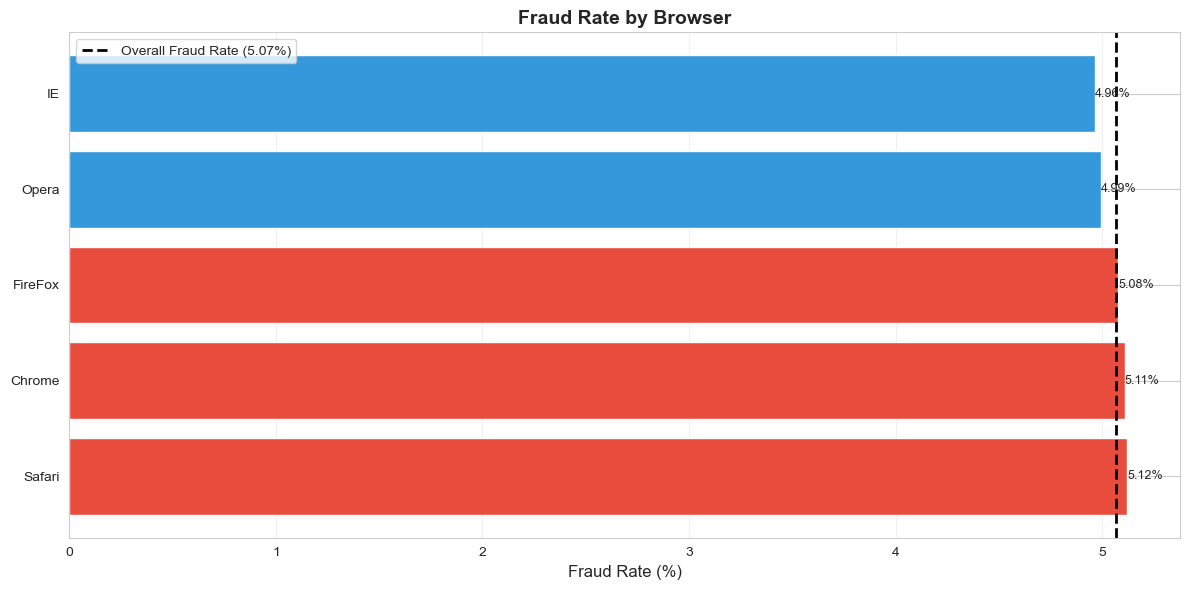


Feature: SEX
sex  Fraud_Rate  Count
  M    5.122905  84171
  F    4.989934  60101


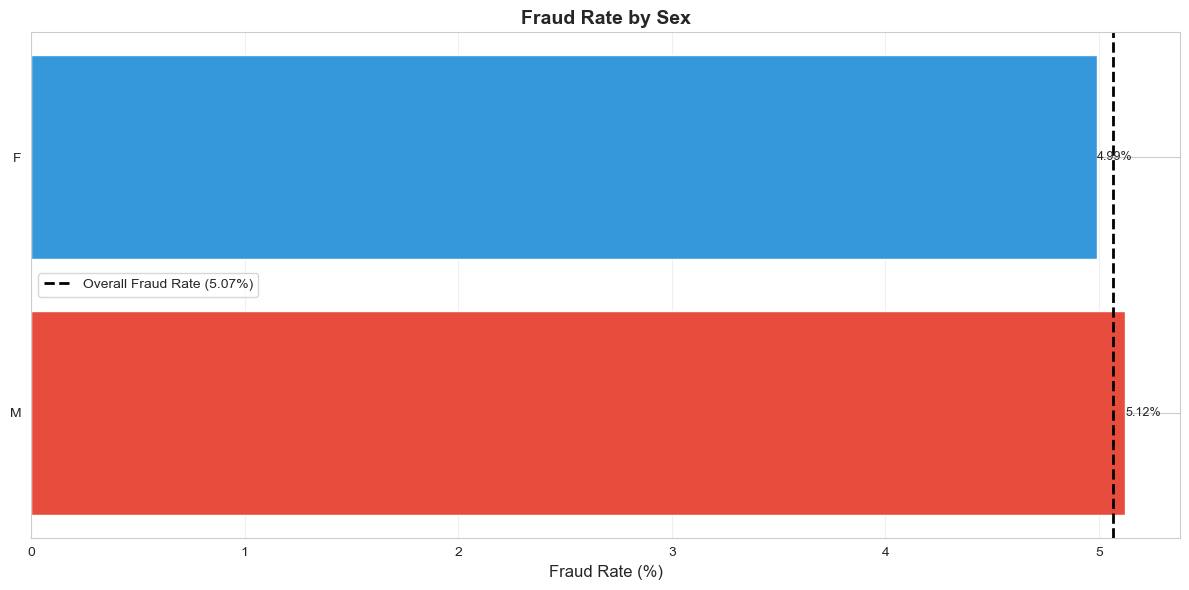


Feature: COUNTRY
                             country  Fraud_Rate  Count
                        Turkmenistan  100.000000      1
               Virgin Islands (U.S.)   33.333333      3
                          Uzbekistan   20.000000     10
                               Malta   18.181818     22
                         Afghanistan   16.666667      6
                       Cote D'ivoire   16.666667      6
                              Malawi   14.285714      7
                          Montenegro   14.285714      7
                             Armenia   13.333333     15
                             Senegal   11.111111      9
                            Honduras   11.111111      9
                             Bolivia   11.111111     45
                             Lebanon   10.714286     28
                             Algeria   10.655738    122
                             Iceland   10.526316     19
                           Sri Lanka   10.000000     20
                              

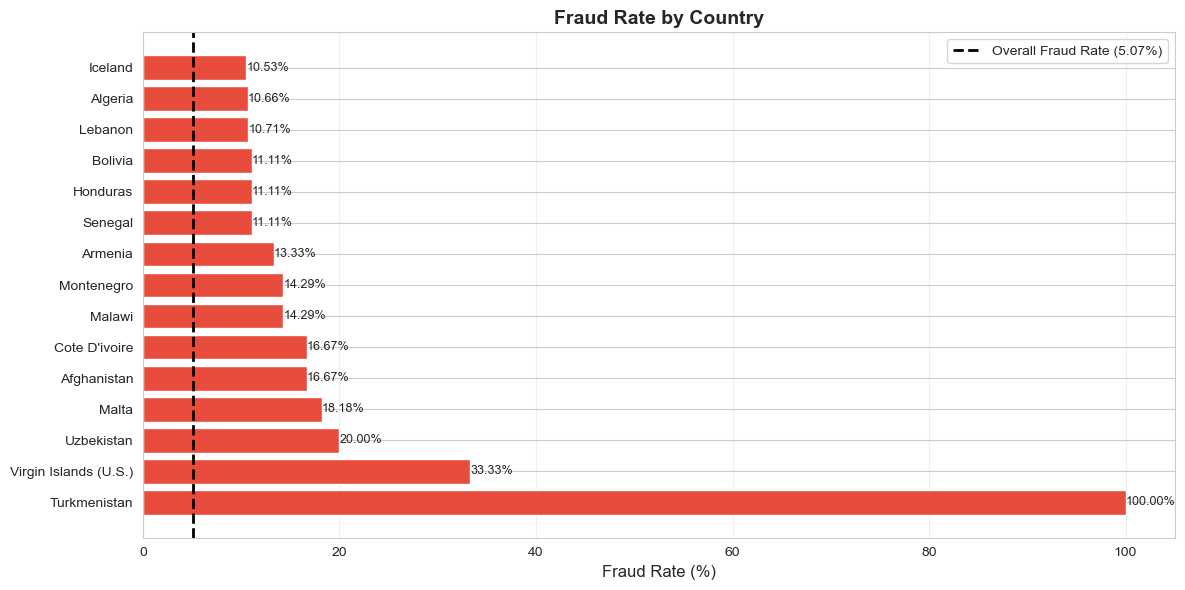


Feature: AGE
        age  Fraud_Rate  Count
Middle-aged    5.088730  52744
      Young    5.088613  30244
      Adult    5.047240  60013
     Senior    4.642014   1271


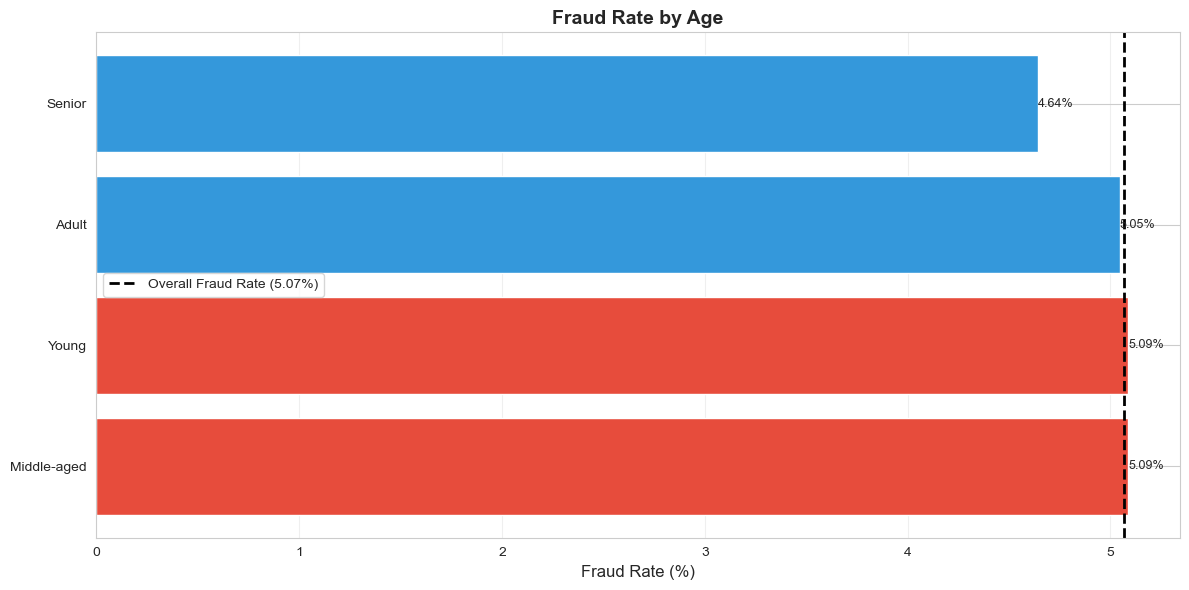

In [14]:
# Calculate fraud rate by category
print("=" * 80)
print("FRAUD RATE BY CATEGORICAL FEATURES")
print("=" * 80)

for feature in categorical_features:
    print(f"\n{'='*80}")
    print(f"Feature: {feature.upper()}")
    print(f"{'='*80}")
    
    fraud_rate = df.groupby(feature)['class'].agg(['mean', 'count']).reset_index()
    fraud_rate.columns = [feature, 'Fraud_Rate', 'Count']
    fraud_rate['Fraud_Rate'] = fraud_rate['Fraud_Rate'] * 100
    fraud_rate = fraud_rate.sort_values('Fraud_Rate', ascending=False)
    
    print(fraud_rate.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 6))
    
    # Get top categories if too many
    if len(fraud_rate) > 15:
        fraud_rate = fraud_rate.head(15)
    
    bars = plt.barh(range(len(fraud_rate)), fraud_rate['Fraud_Rate'], 
                    color=['#e74c3c' if x > df['class'].mean() * 100 else '#3498db' 
                           for x in fraud_rate['Fraud_Rate']])
    plt.yticks(range(len(fraud_rate)), fraud_rate[feature])
    plt.xlabel('Fraud Rate (%)', fontsize=12)
    plt.title(f'Fraud Rate by {feature.replace("_", " ").title()}', 
              fontsize=14, fontweight='bold')
    plt.axvline(x=df['class'].mean() * 100, color='black', linestyle='--', 
                linewidth=2, label=f'Overall Fraud Rate ({df["class"].mean()*100:.2f}%)')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (idx, row) in enumerate(fraud_rate.iterrows()):
        plt.text(row['Fraud_Rate'], i, f"{row['Fraud_Rate']:.2f}%", 
                va='center', ha='left', fontsize=9)
    
    plt.tight_layout()
    plt.show()


### 10. Summary Statistics - Key Insights


In [15]:
print("=" * 80)
print("KEY INSIGHTS SUMMARY")
print("=" * 80)

print(f"\n1. Dataset Overview:")
print(f"   - Total samples: {len(df):,}")
print(f"   - Features: {len(numerical_features) + len(categorical_features)}")
print(f"   - Numerical features: {len(numerical_features)}")
print(f"   - Categorical features: {len(categorical_features)}")

print(f"\n2. Target Variable:")
print(f"   - Fraud cases: {df['class'].sum():,} ({df['class'].mean()*100:.2f}%)")
print(f"   - Non-fraud cases: {(df['class']==0).sum():,} ({(df['class']==0).mean()*100:.2f}%)")
print(f"   - Imbalance ratio: {class_counts[0] / class_counts[1]:.2f}:1")

print(f"\n3. Top Correlated Features with Target:")
top_corr = target_correlations.abs().nlargest(5)
for feature, corr in top_corr.items():
    direction = "positive" if target_correlations[feature] > 0 else "negative"
    print(f"   - {feature}: {target_correlations[feature]:.3f} ({direction})")

print(f"\n4. Numerical Features - Mean Difference (Fraud vs Non-Fraud):")
for feature in numerical_features:
    fraud_mean = df[df['class'] == 1][feature].mean()
    non_fraud_mean = df[df['class'] == 0][feature].mean()
    diff = fraud_mean - non_fraud_mean
    diff_pct = (diff / non_fraud_mean) * 100 if non_fraud_mean != 0 else 0
    print(f"   - {feature}: {diff:.2f} ({diff_pct:+.1f}%)")

print(f"\n5. Data Quality:")
print(f"   - Missing values: {df.isnull().sum().sum()}")
print(f"   - Duplicate rows: {df.duplicated().sum()}")

print("\n" + "=" * 80)


KEY INSIGHTS SUMMARY

1. Dataset Overview:
   - Total samples: 144,272
   - Features: 9
   - Numerical features: 4
   - Categorical features: 5

2. Target Variable:
   - Fraud cases: 7,311 (5.07%)
   - Non-fraud cases: 136,961 (94.93%)
   - Imbalance ratio: 18.73:1

3. Top Correlated Features with Target:
   - device_count: 0.260 (positive)
   - user_count_per_device: 0.260 (positive)
   - account_age_minutes: -0.036 (negative)
   - source: -0.003 (negative)
   - sex: 0.003 (positive)

4. Numerical Features - Mean Difference (Fraud vs Non-Fraud):
   - purchase_value: 0.07 (+0.2%)
   - account_age_minutes: -8327.45 (-9.6%)
   - device_count: 1.33 (+119.0%)
   - user_count_per_device: 1.33 (+119.0%)

5. Data Quality:
   - Missing values: 0
   - Duplicate rows: 1



### 11. Save Analysis Results


In [16]:
# Save target correlations
target_correlations_df = pd.DataFrame({
    'feature': target_correlations.index,
    'correlation': target_correlations.values
})
target_correlations_df.to_csv("artifacts/target_correlations.csv", index=False)
print("Target correlations saved to: artifacts/target_correlations.csv")

print("\n✓ Analysis complete! Ready for model training.")


Target correlations saved to: artifacts/target_correlations.csv

✓ Analysis complete! Ready for model training.
